# Problem 1

# Problem 2.1

In [156]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

In [157]:
# labels for later
master_labels = ["T-shirt", "Pants", "Pullover" , "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# prepare data loaders
batch_size = 128

train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [158]:
class ConditioNet(nn.Module):
    def __init__(self, n_class, n_in, n_hid, z_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_in + n_class, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [159]:
def loss_function(recon_x, x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [174]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        target_onehot = torch.zeros(data.shape[0], 10)
        target_onehot[range(data.shape[0]), target] = 1
        data_adj = torch.cat((data, target_onehot), dim=1)
        
        data = data.to(device)
        data_adj = data_adj.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(data_adj)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            target_onehot = torch.zeros(data.shape[0], 10)
            target_onehot[range(data.shape[0]), target] = 1
            data_adj = torch.cat((data, target_onehot), dim=1)
            
            data = data.to(device)
            data_adj = data_adj.to(device)
            
            output, mu, logvar = model(data_adj)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [180]:
# set up model training

seed = 1
optimizer_name = 'Adam'


num_epochs = 10
lr = 0.001
n_in = 28*28
n_hid = 400
z_dim = 20

device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# train model

vae = VAE(10, n_in, n_hid, z_dim).to(device)

optimizer = make_optimizer(optimizer_name, vae, lr=lr)

for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader, optimizer, epoch)

test(vae, device, test_loader, epoch)

Train(1)[0%]: Loss: 70557.2422
Train(1)[50%]: Loss: 24453.9116
Train(1)[100%]: Loss: 20938.8333
Train(2)[0%]: Loss: 16410.9121
Train(2)[50%]: Loss: 15810.1881
Train(2)[100%]: Loss: 15494.2652
Train(3)[0%]: Loss: 15157.2705
Train(3)[50%]: Loss: 14773.3087
Train(3)[100%]: Loss: 14639.9220
Train(4)[0%]: Loss: 14426.1504
Train(4)[50%]: Loss: 14317.6751
Train(4)[100%]: Loss: 14253.7383
Train(5)[0%]: Loss: 13676.8594
Train(5)[50%]: Loss: 14084.6407
Train(5)[100%]: Loss: 14028.0665
Train(6)[0%]: Loss: 13430.2773
Train(6)[50%]: Loss: 13926.8859
Train(6)[100%]: Loss: 13880.3653
Train(7)[0%]: Loss: 13550.4844
Train(7)[50%]: Loss: 13761.5251
Train(7)[100%]: Loss: 13766.7236
Train(8)[0%]: Loss: 14118.6807
Train(8)[50%]: Loss: 13708.6880
Train(8)[100%]: Loss: 13695.2622
Train(9)[0%]: Loss: 13658.7227
Train(9)[50%]: Loss: 13639.2536
Train(9)[100%]: Loss: 13621.6774
Train(10)[0%]: Loss: 14095.2363
Train(10)[50%]: Loss: 13604.1015
Train(10)[100%]: Loss: 13577.6510
Test(10): Loss: 13524.8333


13524.8332953125

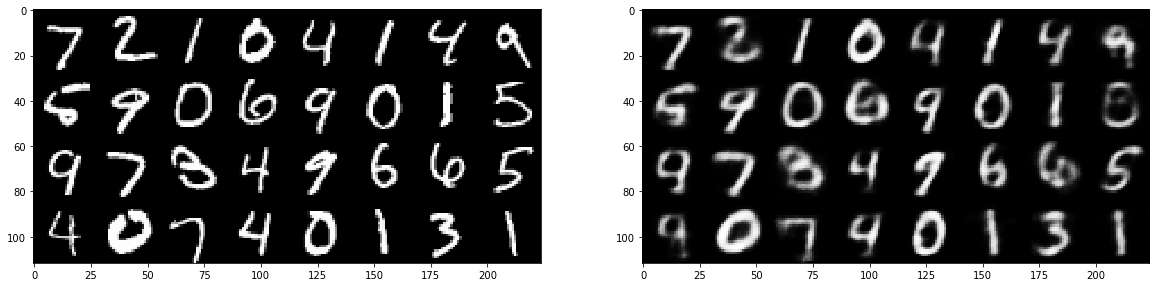

In [179]:
# generate 10 images per class (dress, coat, sandal, sneaker)
# generate manifold plot (tips in homework)

def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()
    
data, target = next(iter(test_loader))
data = data[:32]
target = target[:32]
data_size = data.size()

data = data.view(data.size(0),-1)
target_onehot = torch.zeros(data.shape[0], 10)
target_onehot[range(data.shape[0]), target] = 1
data_adj = torch.cat((data, target_onehot), dim=1)

data_adj = data_adj.to(device)

output, _, _ = vae(data_adj)
output = output.detach()

show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

# Problem 2.2